In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [7]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split
import torch.optim as optim 
import numpy as np
import os
import math
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2
from PIL import Image
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [8]:
class AddGaussianNoise(object):
  def __init__(self, mean=0.0, variance=1.0, amplitude=1.0):
    self.mean = mean
    self.variance = variance
    self.amplitude = amplitude

  def __call__(self, img):
    img = np.array(img)
    # h, w, c = img.shape
    N = self.amplitude * np.random.normal(loc=self.mean, scale=self.variance, size=img.shape)
    # N = np.repeat(N, c, axis=2)
    img = N + img
    img[img > 255] = 255                      
    img = Image.fromarray(img.astype('uint8')).convert('RGB')
    return img


In [9]:
def load_data(data_set, label_noise, augment_data=False):
    """
    Helper Function to Load data in the form of a tensorflow data set, apply label noise, and return the
    train data and test data.

    Parameters
    ----------
    data_set - str, name of data set to load from tf.keras.datasets
    label_noise - float, percentage of training data to add noise to
    augment_data - boolean, whether or not to use random cropping and horizontal flipping to augment training data
    """

    datasets = ["cifar10", "cifar100", "mnist"]

    # load Cifar 10, Cifar 100, or mnis data set
    if data_set == "cifar10":
      transform1 = transforms.Compose([transforms.ToTensor()])
      transform2 = transforms.Compose([transforms.ToTensor()])
      trainset = torchvision.datasets.CIFAR10(root='/content/gdrive/MyDrive/6699/data', train=True, download=True, transform=transform1)
      testset = torchvision.datasets.CIFAR10(root='/content/gdrive/MyDrive/6699/data', train=False, download=True, transform=transform2)
    # elif data_set == "cifar100":
    #     get_data = tf.keras.datasets.cifar100
    # elif data_set == "mnist":
    #     get_data = tf.keras.datasets.mnist
    else:
      raise Exception(
          f"Please enter a data set from the following options: {datasets}"
      )
    
    # apply label noise to the data set
    if 0 < label_noise:
      random_idx = np.random.choice(
          trainset.data.shape[0], int(label_noise * trainset.data.shape[0])
      )
      rand_labels = np.random.randint(
          low=min(trainset.targets), high=max(trainset.targets), size=len(random_idx)
      )
      # print(trainset.targets[random_idx[0]])
      # print(trainset.targets[random_idx[1]])
      for i in range(len(random_idx)):

        trainset.targets[random_idx[i]] = rand_labels[i]
    # print(trainset.targets[random_idx[0]])
    # print(trainset.targets[random_idx[1]])
    return trainset, testset

In [10]:
def CNN(width):
  layers = nn.Sequential(
      nn.Conv2d(in_channels=3, out_channels=width, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(width),
      nn.ReLU(),
      # nn.MaxPool2d(kernel_size=2, stride=2),
      
      nn.Conv2d(in_channels=width, out_channels=2*width, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(2*width),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),

      nn.Conv2d(in_channels=2*width, out_channels=4*width, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(4*width),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),

      nn.Conv2d(in_channels=4*width, out_channels=8*width, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(8*width),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),

      nn.MaxPool2d(kernel_size=4, stride=4),
      nn.ReLU(),
      nn.Flatten(),
      nn.Linear(in_features=8*width, out_features=10),

    )

  return layers

In [11]:
model = CNN(1)
x = torch.rand([5,3,32,32])
for name, module in model.named_children():
  x = module(x)
  # print(name)
  print("({}) : {}".format(name,x.shape))

(0) : torch.Size([5, 1, 32, 32])
(1) : torch.Size([5, 1, 32, 32])
(2) : torch.Size([5, 1, 32, 32])
(3) : torch.Size([5, 2, 32, 32])
(4) : torch.Size([5, 2, 32, 32])
(5) : torch.Size([5, 2, 32, 32])
(6) : torch.Size([5, 2, 16, 16])
(7) : torch.Size([5, 4, 16, 16])
(8) : torch.Size([5, 4, 16, 16])
(9) : torch.Size([5, 4, 16, 16])
(10) : torch.Size([5, 4, 8, 8])
(11) : torch.Size([5, 8, 8, 8])
(12) : torch.Size([5, 8, 8, 8])
(13) : torch.Size([5, 8, 8, 8])
(14) : torch.Size([5, 8, 4, 4])
(15) : torch.Size([5, 8, 1, 1])
(16) : torch.Size([5, 8, 1, 1])
(17) : torch.Size([5, 8])
(18) : torch.Size([5, 10])


In [12]:
class inverse_squareroot_lr:
  """
  This is the learning rate used with SGD in the paper (Inverse square root decay).
  Learning Rate starts at 0.1 and then drops every 512 batches.
  """

  def __init__(self, n_steps=512, init_lr=0.1):
      self.n = n_steps
      self.gradient_steps = 0
      self.init_lr = init_lr

  def __call__(self):
      lr = self.init_lr / math.sqrt(
          1.0 + math.floor(self.gradient_steps / self.n)
      )
      self.gradient_steps += 1
      return lr

In [13]:
class Classifier():

    def __init__(self, name, model, trainset, testset, use_cuda=False):
        
        '''
        @name: Experiment name. Will define stored results etc. 
        @model: Either a GradBasicNet() or a GradAlexNet()
        @dataloaders: Dictionary with keys train, val and test and corresponding dataloaders
        @class_names: list of classes, where the idx of class name corresponds to the label used for it in the data
        @use_cuda: whether or not to use cuda
        '''
        
        self.name = name
        if use_cuda and not torch.cuda.is_available():
            raise Exception("Asked for CUDA but GPU not found")
            
        self.use_cuda = use_cuda
        
        self.model = model.to('cuda' if use_cuda else 'cpu')
        self.trainset = trainset
        self.testset = testset
        self.init_lr = 0.1
        self.criterion = nn.CrossEntropyLoss() #use cross entropy loss
        self.optim = optim.SGD(model.parameters(), lr=self.init_lr) #use SGD with suggest hyperparams; you must select all the model params
        # self.optim = optim.SGD(model.parameters(), lr=0.1)


        save_path = os.path.join(os.getcwd(), 'models', self.name)
        if not os.path.exists(save_path):
            os.makedirs(save_path)
            
        self.save_path = save_path

    def train(self, epochs, save=True):
        '''
        @epochs: number of epochs to train
        @save: whether or not to save the checkpoints
        '''

        # best_val_accuracy = - math.inf
        gradient_steps = 0
        for epoch in tqdm(range(epochs)):

            self.model.train()

            n_step = 512
            
            # TODO Iterate over the training dataloader (see how it is done for validation below) and make sure
            # to call the optim.zero_grad(), loss.backward() and optim.step()
            for idx, data in enumerate(self.trainset):
                inputs, labels = data

                inputs = inputs.to('cuda' if self.use_cuda else 'cpu')
                labels = labels.to('cuda' if self.use_cuda else 'cpu')

                outputs = self.model(inputs)

                loss = self.criterion(outputs, labels)

                optimizer = self.optim

                lr = self.init_lr / math.sqrt(1.0 + math.floor(gradient_steps/n_step))
                gradient_steps += 1
                optimizer.param_groups[0]['lr'] = lr
                # print(gradient_steps, optimizer.param_groups[0]['lr'])

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        if save:
            #  Make sure that your saving pipeline is working well. 
            # Is os library working on your file system? 
            # Is your model being saved and reloaded fine? 
            # When you do the kernel viz, activation maps, 
            # and GradCAM you must be using the model you have saved before.
            
            # torch.save(self.model.state_dict(), os.path.join(self.save_path, f'epoch_{epoch}.pt'))
            
            torch.save(self.model.state_dict(), os.path.join(self.save_path, 'best.pt'))
                  

        # print('Done training!')                       

    def evaluate_train(self):
        
        try:
            assert os.path.exists(os.path.join(self.save_path, 'best.pt'))
            
        except:
            print('It appears you are testing the model without training. Please train first')
            return
        
        self.model.load_state_dict(torch.load(os.path.join(self.save_path, 'best.pt')))
        self.model.eval()

        #total = len(self.dataloaders['test'])
        
        correct = 0.0
        total = 0.0
        for idx, data in enumerate(self.trainset):
            
                inputs, labels = data

                inputs = inputs.to('cuda' if self.use_cuda else 'cpu')
                labels = labels.to('cuda' if self.use_cuda else 'cpu')
                
                outputs = self.model(inputs)
                _, predicted = torch.max(outputs, 1)
                
                total += labels.shape[0]
                correct += (predicted == labels).sum().item()
                
        # print(f'Training Accuracy: {100 * correct/total}%')
        return 1 - correct/total

    def evaluate_test(self):
        
        try:
            assert os.path.exists(os.path.join(self.save_path, 'best.pt'))
            
        except:
            print('It appears you are testing the model without training. Please train first')
            return
        
        self.model.load_state_dict(torch.load(os.path.join(self.save_path, 'best.pt')))
        self.model.eval()

        #total = len(self.dataloaders['test'])
        
        correct = 0.0
        total = 0.0
        for idx, data in enumerate(self.testset):
            
                inputs, labels = data

                inputs = inputs.to('cuda' if self.use_cuda else 'cpu')
                labels = labels.to('cuda' if self.use_cuda else 'cpu')
                
                outputs = self.model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.shape[0]
                correct += (predicted == labels).sum().item()
                
        # print(f'Testing Accuracy: {100 * correct/total}%')
        return 1 - correct/total

Files already downloaded and verified
Files already downloaded and verified


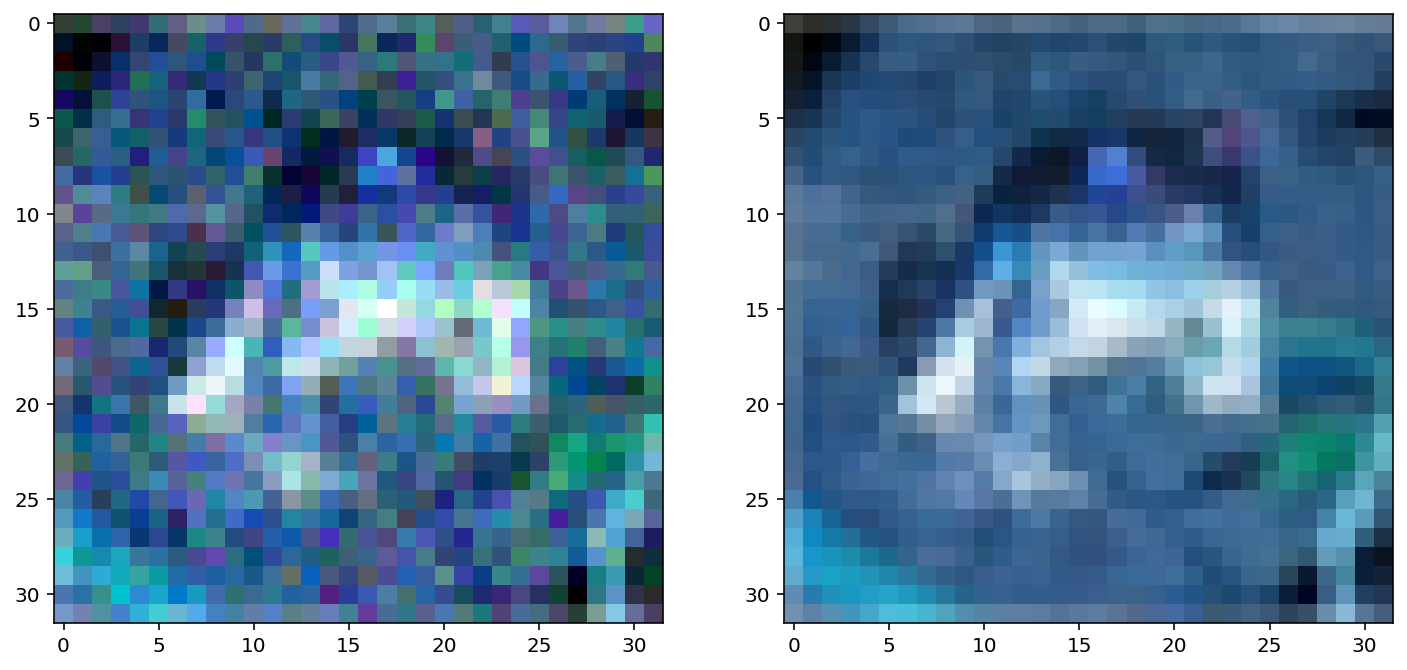

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
pre = axes[0]
cur = axes[1]
trainset, testset = load_data("cifar10", 0)
img = next(iter(trainset.data))

noise = 20 * np.random.normal(0, 1, img.shape)
img2 = img + noise
img2 = np.clip(img2, 0, 255).astype("float32")

img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

cur.imshow(img/255)
pre.imshow(img2/255)
# plt.show()

In [14]:
batch_size = 128
num_workers = 2
epochs = 1000 # total number desirec SGD steps / number batches per epoch
label_noise_int = 0
label_noise = label_noise_int / 100
trainset, testset = load_data("cifar10", label_noise)

trainset, _ = random_split(trainset, [10000, len(trainset)-10000])
testset, _ = random_split(testset, [2000, len(testset)-2000])

trainset = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
testset = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
train_result = []
test_result = []
convnet_widths = [(i + 1) for i in range(16)] + [16 + 4*(i + 1) for i in range(12)] 
for width in convnet_widths:
  experiment_name = f'CNN_{width}_{label_noise_int}%noise'  #Provide name to model experiment
  model_name = f'CNN_{width}_{label_noise_int}%noise' 

  model = CNN(width)

  classifier = Classifier(experiment_name, model, trainset, testset, use_cuda=True)

  classifier.train(epochs=epochs)
  train_error = classifier.evaluate_train()
  test_error = classifier.evaluate_test()
  print(f'width = {width}, train_error = {train_error}, test_error = {test_error}')
  train_result.append(train_error)
  test_result.append(test_error)

100%|██████████| 1000/1000 [16:26<00:00,  1.01it/s]


width = 1, train_error = 0.5778, test_error = 0.618


100%|██████████| 1000/1000 [16:29<00:00,  1.01it/s]


width = 2, train_error = 0.3822, test_error = 0.527


 36%|███▌      | 358/1000 [05:57<10:30,  1.02it/s]

In [ ]:
train_result = []
test_result = []
convnet_widths = [(i + 1) for i in range(2, 16)] + [16 + 4*(i + 1) for i in range(12)] 
for width in convnet_widths:
  experiment_name = f'CNN_{width}_{label_noise_int}%noise'  #Provide name to model experiment
  model_name = f'CNN_{width}_{label_noise_int}%noise' 

  model = CNN(width)

  classifier = Classifier(experiment_name, model, trainset, testset, use_cuda=True)

  classifier.train(epochs=epochs)
  train_error = classifier.evaluate_train()
  test_error = classifier.evaluate_test()
  print(f'width = {width}, train_error = {train_error}, test_error = {test_error}')
  train_result.append(train_error)
  test_result.append(test_error)

100%|██████████| 1000/1000 [16:40<00:00,  1.00s/it]


width = 3, train_error = 0.2894, test_error = 0.5225


100%|██████████| 1000/1000 [16:47<00:00,  1.01s/it]


width = 4, train_error = 0.24839999999999995, test_error = 0.529


100%|██████████| 1000/1000 [17:07<00:00,  1.03s/it]


width = 5, train_error = 0.007900000000000018, test_error = 0.48050000000000004


100%|██████████| 1000/1000 [17:14<00:00,  1.03s/it]


width = 6, train_error = 0.0, test_error = 0.4525


100%|██████████| 1000/1000 [17:30<00:00,  1.05s/it]


width = 7, train_error = 0.0007000000000000339, test_error = 0.43200000000000005


100%|██████████| 1000/1000 [17:43<00:00,  1.06s/it]


width = 8, train_error = 0.0, test_error = 0.396


100%|██████████| 1000/1000 [18:02<00:00,  1.08s/it]


width = 9, train_error = 0.0, test_error = 0.38249999999999995


100%|██████████| 1000/1000 [18:45<00:00,  1.13s/it]


width = 10, train_error = 0.0, test_error = 0.374


100%|██████████| 1000/1000 [19:08<00:00,  1.15s/it]


width = 11, train_error = 0.0, test_error = 0.366


100%|██████████| 1000/1000 [18:54<00:00,  1.13s/it]


width = 12, train_error = 0.0, test_error = 0.348


100%|██████████| 1000/1000 [19:07<00:00,  1.15s/it]


width = 13, train_error = 0.0, test_error = 0.352


100%|██████████| 1000/1000 [19:15<00:00,  1.16s/it]


width = 14, train_error = 0.0, test_error = 0.33799999999999997


100%|██████████| 1000/1000 [19:39<00:00,  1.18s/it]


width = 15, train_error = 0.0, test_error = 0.33799999999999997


100%|██████████| 1000/1000 [20:01<00:00,  1.20s/it]


width = 16, train_error = 0.0, test_error = 0.32199999999999995


100%|██████████| 1000/1000 [32:43<00:00,  1.96s/it]


width = 20, train_error = 0.0, test_error = 0.3135


100%|██████████| 1000/1000 [27:44<00:00,  1.66s/it]


width = 24, train_error = 0.0, test_error = 0.29400000000000004


100%|██████████| 1000/1000 [31:51<00:00,  1.91s/it]


width = 28, train_error = 0.0, test_error = 0.28700000000000003


100%|██████████| 1000/1000 [29:41<00:00,  1.78s/it]


width = 32, train_error = 0.0, test_error = 0.27849999999999997


100%|██████████| 1000/1000 [35:33<00:00,  2.13s/it]


width = 36, train_error = 0.0, test_error = 0.271


100%|██████████| 1000/1000 [43:40<00:00,  2.62s/it]


width = 40, train_error = 0.0, test_error = 0.28400000000000003


100%|██████████| 1000/1000 [47:16<00:00,  2.84s/it]


width = 44, train_error = 0.0, test_error = 0.27549999999999997


100%|██████████| 1000/1000 [51:34<00:00,  3.09s/it]


width = 48, train_error = 0.0, test_error = 0.27


100%|██████████| 1000/1000 [46:00<00:00,  2.76s/it]


width = 52, train_error = 0.0, test_error = 0.266


100%|██████████| 1000/1000 [54:04<00:00,  3.24s/it]


width = 56, train_error = 0.0, test_error = 0.271


 32%|███▏      | 315/1000 [18:19<43:00,  3.77s/it]

In [ ]:
train_result = []
test_result = []
convnet_widths = [(i + 1) for i in range(13,16)] + [16 + 4*(i + 1) for i in range(12)] 
for width in convnet_widths:
  experiment_name = f'CNN_{width}_{label_noise_int}%noise'  #Provide name to model experiment
  model_name = f'CNN_{width}_{label_noise_int}%noise' 

  model = CNN(width)

  classifier = Classifier(experiment_name, model, trainset, testset, use_cuda=True)

  classifier.train(epochs=epochs)
  train_error = classifier.evaluate_train()
  test_error = classifier.evaluate_test()
  print(f'width = {width}, train_error = {train_error}, test_error = {test_error}')
  train_result.append(train_error)
  test_result.append(test_error)

100%|██████████| 1000/1000 [46:12<00:00,  2.77s/it]


width = 14, train_error = 0.00029999999999996696, test_error = 0.39849999999999997


100%|██████████| 1000/1000 [46:42<00:00,  2.80s/it]


width = 15, train_error = 0.00029999999999996696, test_error = 0.36750000000000005


100%|██████████| 1000/1000 [46:53<00:00,  2.81s/it]


width = 16, train_error = 0.00039999999999995595, test_error = 0.385


100%|██████████| 1000/1000 [47:04<00:00,  2.82s/it]


width = 20, train_error = 9.999999999998899e-05, test_error = 0.354


100%|██████████| 1000/1000 [47:24<00:00,  2.84s/it]


width = 24, train_error = 0.0, test_error = 0.34750000000000003


100%|██████████| 1000/1000 [47:43<00:00,  2.86s/it]


width = 28, train_error = 0.0, test_error = 0.35350000000000004


 29%|██▊       | 287/1000 [13:33<33:41,  2.83s/it]


KeyboardInterrupt: ignored